<a href="https://colab.research.google.com/github/spinto88/Clases_y_tutoriales/blob/main/Topicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de tópicos

En esta notebook vamos a descomponer en tópicos un conjunto de textos. La descomposición en tópicos pueden pensarla a la vez como un proceso de reducción dimensional (al describir los datos en el espacio de tópicos en vez del espacio original de features), o como un proceso de *clustering* al agrupar los textos en dichos tópicos.

Vamos a aplicar el algoritmo NMF sobre un dataset de noticias políticas.

In [ ]:
# Importamos las librerías habituales
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

In [ ]:
# Importamos nltk para extraer stopwords
import nltk
nltk.download('stopwords')

# Librería para hacer wordclouds
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Objetos de sklearn para hacer tópicos
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf

# Algoritmos de descomposición de tópicos
from sklearn.decomposition import NMF

Podemos cargar el dataset desde nuestro drive en caso de que sea muy pesado.
Para ello primero lo subimos al drive y luego nos conectamos con él:


In [ ]:
# Conexión con el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargamos el dataset con el que vamos a trabajar desde la carpeta de la materia. Los datos se corresponden con notas de las secciones políticas de La Nación, Clarín, Infobae y Página 12 desde el 31-07-2017 al 31-10-2017.

In [ ]:
# Path de nuestro dataset (recuerden subirlo previamente al drive)
filename = 'drive/My Drive/Notas_politicas.csv'

# Carga del dataset
df = pd.read_csv(filename)

# Vemos las primeras filas
df.head(10)

,date,title,subtitle,prefix,body,section,newspaper,author,tag,url
0,2017-08-24,"Martínez Rojas, el empresario buscado por la J...",Hace un año y medio tuvo en sus manos Radio Am...,Empresarios de medios K,Mariano Martínez Rojas tiene menos de 40 años ...,Política,Clarín,Alejandro Alfie,NaN,https://www.clarin.com/politica/martinez-rojas...
1,2017-10-25,Un informe preliminar de Prefectura indica que...,Precisa que la zona donde estaba el cuerpo era...,El caso del artesano,El informe preliminar de Prefectura Naval Arge...,Política,Clarín,Claudio Andrade,NaN,https://www.clarin.com/politica/prefectura-san...
2,2017-08-20,Qué puede pasar con los votantes de Massa y Ra...,Es una consultora online que erró por muy poco...,Elecciones 2017,Acertó el orden de los primeros cinco puestos ...,Política,Clarín,Eduardo Paladini,NaN,https://www.clarin.com/politica/puede-pasar-vo...
3,2017-09-19,Los rastrillajes confirmaron cómo se modificó ...,"En el mega operativo de ayer, las fuerzas de s...",La búsqueda del artesano,Las evidencias son más contundentes. Y fueron ...,Política,Clarín,Claudio Andrade,NaN,https://www.clarin.com/politica/rastrillajes-c...
4,2017-10-03,Escándalo: una candidata a diputada del macris...,"Es Joanna Picetti, octava en la lista de Vamos...",Elecciones 2017,Envalentonado tras el contundente triunfo en l...,Política,Clarín,Ignacio Ortelli,NaN,https://www.clarin.com/politica/escandalo-cand...
5,2017-10-08,"Paso a paso, cómo mataron al fiscal Alberto Ni...",Los extractos más contundentes de la pericia a...,Habla de 2 victimarios,Mientras el fiscal Eduardo Taiano está evaluan...,Política,Clarín,Daniel Santoro,NaN,https://www.clarin.com/politica/paso-paso-mata...
6,2017-09-21,El fiscal de la causa de Río Turbio insiste co...,Stronelli apeló la decisión del juez que había...,Sospechas de corrupción,El fiscal Carlos Stornelli apeló la decisión d...,Política,Clarín,Lucía Salinas,NaN,https://www.clarin.com/politica/fiscal-causa-r...
7,2017-10-09,Cristina Kirchner: 'El Poder Judicial actúa co...,La ex presidenta es candidata a senadora nacio...,En conferencia de prensa,La ex presidenta Cristina Kirchner criticó hoy...,Política,Clarín,NaN,NaN,https://www.clarin.com/politica/cristina-kirch...
8,2017-08-22,"En un acto que mostró divisiones, el sector du...",El único orador fue el moyanista Juan Carlos S...,Protesta sindical,Pese a las fuertes tensiones internas entre lo...,Política,Clarín,Guido Braslavsky,NaN,https://www.clarin.com/politica/acto-mostro-di...
9,2017-10-29,Cristina se quejó porque le sacaron de su pens...,Son $ 20.000 que el juez Bonadio le descontó p...,Los problemas judiciales de la ex presidenta,“¿Cómo son sus condiciones de vida?”. “Normale...,Política,Clarín,Lucía Salinas,NaN,https://www.clarin.com/politica/cristina-quejo...


Vamos a quedarnos solo con el texto de las notas. Primero borramos aquellas notas que no tengan datos del cuerpo de la misma:

In [ ]:
# Borramos y sobreescribimos aquellas filas que tengan un NaN en la columna body
df.dropna(subset = ['body'], inplace = True)

# Creamos una lista de textos
texts = df.body.copy().to_list()

In [ ]:
# Cuantos documentos tenemos?
len(texts)

11102

### Construcción de la matriz documentos-términos

Vamos a construir esta matriz con valorización tf-idf, es decir, además de la frecuencia del término vamos a ponderar la especificidad.
Esto lo hacemos en dos pasos: primero, describimos nuestros datos mediante frecuencia de términos; luego, le agregamos la valorización de la especificidad.
Vamos además a remover las *stopwords* obtenidas de *nltk*.

In [ ]:
# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('spanish')

# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 2, max_df = 0.70, stop_words = stopwords, lowercase = True, ngram_range = (1, 1))

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(texts)

# Dimensions de la matriz doc-tér
print(x_count.shape)

(11102, 50992)


x_count es una matriz donde cada elemento indica la cantidad de veces que aparece el término asociado a la columna al documento asociado con la fila.
Inspeccionemos un poco cómo se ve una parte de la matriz:

In [ ]:
# Si aparece una leyenda que dice "sparse matrix" usamos el todense() para verla explícitamente
x_count[0, 4000:4100].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Cómo sabemos qué término está asociado a cada columna?

In [ ]:
# Diccionario término - índice
count.vocabulary_

{'mariano': 31607,
 'martínez': 31696,
 'rojas': 43558,
 'menos': 32167,
 '40': 709,
 'años': 6909,
 'dueño': 18329,
 'grupo': 24925,
 'luxe': 30909,
 'dedicaba': 14803,
 'organizar': 35176,
 'shows': 44973,
 'musicales': 33432,
 'eventos': 21496,
 'provincia': 39470,
 'corrientes': 13386,
 'hizo': 25639,
 'conocido': 12138,
 'sergio': 44800,
 'szpolski': 46722,
 'transfirió': 48106,
 'radio': 40235,
 'américa': 4153,
 'tiempo': 47467,
 'argentino': 5375,
 'enero': 19683,
 '2016': 405,
 'mes': 32284,
 'siguiente': 45069,
 'dejara': 14982,
 'gobierno': 24614,
 'cristina': 13784,
 'fernández': 22747,
 'kirchner': 29512,
 'época': 50903,
 'hablaba': 25176,
 'reiteradas': 41720,
 'denuncias': 15312,
 'estafas': 21104,
 'comercialización': 10968,
 'autos': 6621,
 'usados': 49103,
 'alta': 3773,
 'gama': 24044,
 'operaciones': 34954,
 'inmobiliarias': 27672,
 'impidió': 26384,
 '23': 463,
 'sido': 44994,
 'mayor': 31882,
 'multimedio': 33347,
 'kirchnerista': 29515,
 'medios': 32005,
 'disol

Invertimos el diccionario anterior para que sea más fácil sacar qué palabra está asociado a un dado término:

In [ ]:
# Objeto índice: término de nuestro vocabulario
vocabulary = {item: key for key, item in count.vocabulary_.items()}
print(vocabulary)

{31607: 'mariano', 31696: 'martínez', 43558: 'rojas', 32167: 'menos', 709: '40', 6909: 'años', 18329: 'dueño', 24925: 'grupo', 30909: 'luxe', 14803: 'dedicaba', 35176: 'organizar', 44973: 'shows', 33432: 'musicales', 21496: 'eventos', 39470: 'provincia', 13386: 'corrientes', 25639: 'hizo', 12138: 'conocido', 44800: 'sergio', 46722: 'szpolski', 48106: 'transfirió', 40235: 'radio', 4153: 'américa', 47467: 'tiempo', 5375: 'argentino', 19683: 'enero', 405: '2016', 32284: 'mes', 45069: 'siguiente', 14982: 'dejara', 24614: 'gobierno', 13784: 'cristina', 22747: 'fernández', 29512: 'kirchner', 50903: 'época', 25176: 'hablaba', 41720: 'reiteradas', 15312: 'denuncias', 21104: 'estafas', 10968: 'comercialización', 6621: 'autos', 49103: 'usados', 3773: 'alta', 24044: 'gama', 34954: 'operaciones', 27672: 'inmobiliarias', 26384: 'impidió', 463: '23', 44994: 'sido', 31882: 'mayor', 33347: 'multimedio', 29515: 'kirchnerista', 32005: 'medios', 17704: 'disolviendo', 22457: 'falta', 23014: 'financiamient

Entonces por ejemplo si vemos que:

In [ ]:
x_count[0, 4019]

1

Sabemos que la palabra asociada a dicha columna es:

In [ ]:
vocabulary[4019]

'amenazas'

Podemos tranquilamente trabajar sobre la matriz de documentos descritos a través de la frecuencia de las palabras o bien, como es habitual, ponderar la especificidad de los términos mediante tf-idf. Esto lo hacemos de la siguiente manera:

In [ ]:
# Creamos el objeto tf-idf. Le decimos además que devuelva los
# vectores documento con norma euclídea igual a 1 (norm = 'l2')
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)

In [ ]:
x_tfidf.shape

(11102, 50992)

Ahora los elementos de esta matriz no son tan interpretables como cuando solo medíamos frecuenciade aparición:

In [ ]:
x_tfidf[0, 4019]

0.03298131998525653

### Aplicación de NMF sobre el corpus

Vamos a buscar los tópicos en nuestro corpus de textos a través de la descomposición en matrices no-negativas. Elijamos un número arbitrario de tópicos:

In [ ]:
# Elijamos la cantidad de tópicos
n_components = 6

# Construímos el objeto NMF con los tópicos indicados
nmf = NMF(n_components = n_components)

# Aplicamos sobre nuestros datos
x_nmf = nmf.fit_transform(x_tfidf)

# Dimensión de la matriz transformada
print(x_nmf.shape)

(11102, 6)


Que obtenemos?

In [ ]:
# Peso de los tópicos asociados a un dado elemento
x_nmf[1]

array([0.        , 0.00528148, 0.07225389, 0.00242291, 0.00729241,
       0.        ])

Para una interpretación más sencilla, normalizamos cada fila de la matriz x_nmf, la cual para referirnos a las diapositivas de las clases la llamaremos matriz H:

In [ ]:
# Matriz H = x_nmf
H = x_nmf.copy()

Para normalizar las filas usamos un objeto especial que lo hace:

In [ ]:
# Normalizador
from sklearn.preprocessing import Normalizer

# Creamos un objeto para normalizar a que la suma dé 1
norm = Normalizer('l1')

# Sobreescribimos sobre la matriz de documentos-tópicos
H = norm.fit_transform(H)

Así podemos identificar a una fila de H como una distribución en el espacio de tópicos:

In [ ]:
# Por ejemplo, el documento 1
H[1]

array([0.        , 0.06053223, 0.82811829, 0.02776955, 0.08357993,
       0.        ])

Por otro lado identificamos la matriz W, que nos va a decir de qué habla cada tópico:

In [ ]:
# Matriz W
W = nmf.components_.copy()

In [ ]:
# Dimensiones
W.shape

(6, 50992)

Podemos hacer los mismo de inspeccionar manualmente qué es cada fila, pero en este caso las filas son un poco más largas y no vamos a poder ver todas las componentenes impresas en pantalla:

In [ ]:
W[0]

array([0.01655479, 0.06987752, 0.        , ..., 0.00717191, 0.03940802,
       0.00029527])

Veamos qué significa cada tópico. Lo que hay que indentificar es cuáles son los índices con mayor peso en cada componente y a qué término le corresponde. Para ello usamos el diccionario "vocabulary" (del estilo "índice: término") y ordenar los índices de mayor a menor en cada componente:

In [ ]:
# Ordenamos los índices de una dada fila de tópicos según el peso
list_sorted = sorted(range(W.shape[1]), reverse = True, key = lambda x: W[1][x])

# Vemos los primeros elementos más pesados
list_sorted[:10]

[42862, 17906, 28168, 15635, 34504, 31474, 50446, 36790, 12124, 32701]

In [ ]:
vocabulary[17906]

'distrito'

Hacemos lo mismo para todos los tópicos e imprimos el resultado en pantalla:

In [ ]:
# Para cada componente
for n in range(n_components):

  # Ordenamos una lista del largo de nuestro vocabulario según el peso en cada componente y nos quedamos con los primeros 10
  list_sorted = sorted(range(W.shape[1]), reverse = True, key = lambda x: W[n][x])[:20]

  # Printeamos los términos asociados a los valores más grande de cada una de las componentes
  print('Topico:')
  print(', '.join([vocabulary[i] for i in list_sorted]))
  print('\n')

Topico:
cristina, cambiemos, elecciones, kirchner, 2017, massa, votos, provincia, randazzo, electoral, paso, unidad, vidal, campaña, octubre, ciudadana, ex, elección, juan, candidato


Topico:
resultados, distrito, interactivo, desarrollado, obtuvieron, mapa, votos, permite, conocer, mirá, 2017, elecciones, candidatos, nacion, votó, cómo, recuento, graneros, añelo, antártida


Topico:
maldonado, santiago, gendarmería, desaparición, caso, otranto, juez, familia, joven, mapuche, comunidad, cuerpo, chubut, esquel, gendarmes, río, bullrich, seguridad, investigación, lof


Topico:
vido, ex, causa, juez, julio, federal, juicio, fiscal, desafuero, boudou, nisman, kirchner, cámara, bonadio, oral, cristina, ministro, justicia, tribunal, indagatoria


Topico:
gobierno, macri, argentina, presidente, cgt, trabajo, si, reforma, país, trabajadores, mauricio, año, años, laboral, política, ser, ley, dijo, social, hoy


Topico:
sala, milagro, cidh, prisión, domiciliaria, jujuy, tupac, amaru, comedero, 

Recordemos que siempre podemos chequear la distribución de una dado documento y cetificar que está bien asignado:

In [ ]:
# Distribucion en tópicos del documento 1
H[1]

In [ ]:
# Texto del documento 1
texts[1]

'El informe preliminar de Prefectura Naval Argentina respecto del hallazgo del cuerpo de Santiago Maldonado el pasado 17 de octubre en el río Chubut indica que el joven muy probablemente  se ahogó al caer a un pozo de 3 metros de profundidad  en una zona de difícil acceso, donde la vegetación es tan abundante que no deja pasar la luz del sol. Los especialistas también relataron que el tatuador  estaba en “posición fetal”, una reacción corporal al agua y a las bajas temperaturas propia de las personas que han perecido ahogadas,  según les indica su experiencia en el tema. Con esto se abona todavía más la teoría de que no hubo violencia contra el joven y que falleció en el caudal por no saber nadar, entre otros factores.   Mirá también   Verdades y miserias alrededor del Testigo E Según indicaron fuentes a  Clarín , el cuerpo se encontraba a 7 metros de la orilla entre ramas, palos y raíces. Se trata de un sector –a 110 metros de la Zona Cero aproximadamente– considerado por los buzos de

Para que sea más fácil visualizar los tópicos, armemos wordclouds, poniendole el peso dado por el algoritmo de NMF:

In [ ]:
def nube_palabras_topico(n_topic, vocabulary, topics_vectors):

  # WordClouds
  wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds

  # Creo la figura
  fig, ax = plt.subplots(figsize = (6,6))

  # 10 términos más pesados
  list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: topics_vectors[n_topic][x])[:10]

  # Diccionario término: peso
  comp_dict = {vocabulary[i]: topics_vectors[n_topic][i] for i in list_sorted}

  # Creo el wordlcoud
  wc = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                 ).generate_from_frequencies(comp_dict)

  ax.set_title('Tópico {}'.format(n_topic))
  ax.imshow(wc)
  ax.axis('off')

  plt.show()

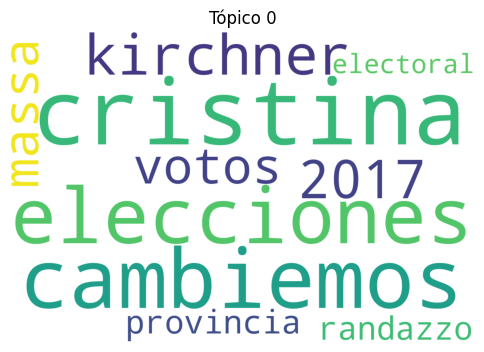

In [ ]:
# Probamos la funcion que creamos
nube_palabras_topico(0, vocabulary, W)

Veamos todos los wordclouds en simultáneo:

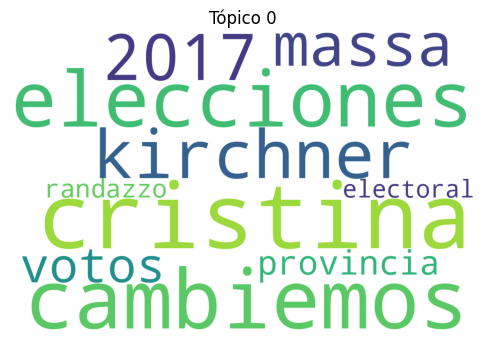

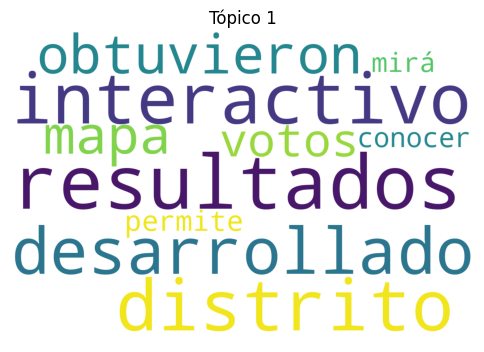

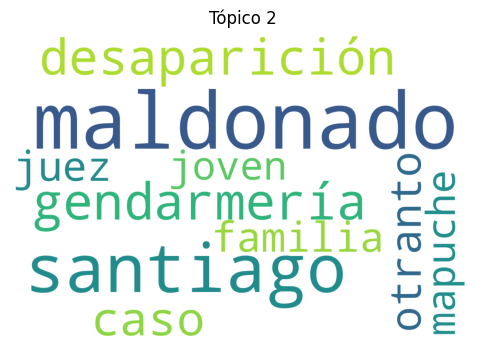

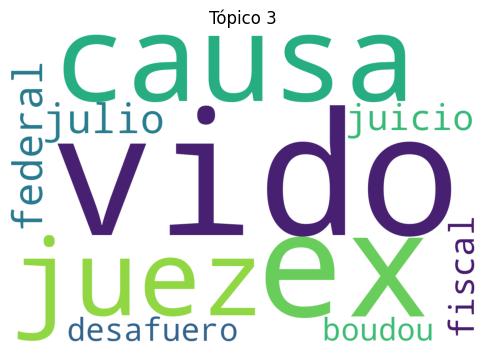

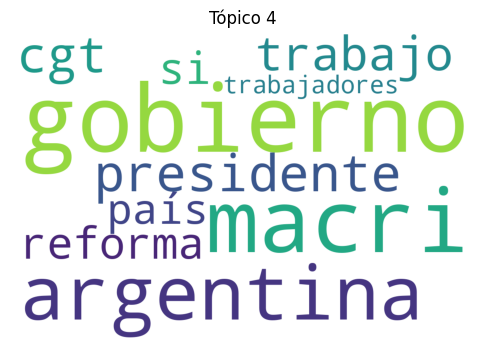

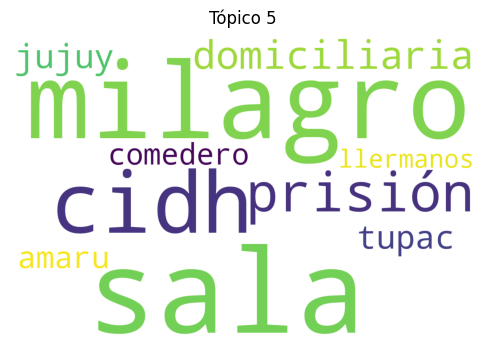

In [ ]:
for n_topic in range(n_components):
  nube_palabras_topico(n_topic, vocabulary, nmf.components_)

#### Evolución de los tópicos

Algo que podemos hacer al identificar los tópicos es ver cómo evolucionan en el tiempo, es decir, si hay tópicos dominantes en determinados períodos. Antes de hacer esto, normalizemos los vectores documentos en el espacio de tópicos para interpretarlos como una distribución:

In [ ]:
# Vamos a incorporar esta información en el dataframe
# Por ej, peso del tópico 0 en cada uno de los documentos
H[:,0]

NameError: ignored

In [ ]:
# Guardemos en el dataframe esta información
for n in range(n_components):
  df[f'nmf_comp{n}'] = H[:,n]

Veamos cómo se ve para un tópico el dataframe, imprimiendo solo un par de columnas:

In [ ]:

df[['date', 'title','nmf_comp1']]

,date,title,nmf_comp1
0,2017-08-24,"Martínez Rojas, el empresario buscado por la J...",0.004063
1,2017-10-25,Un informe preliminar de Prefectura indica que...,0.060532
2,2017-08-20,Qué puede pasar con los votantes de Massa y Ra...,0.000000
3,2017-09-19,Los rastrillajes confirmaron cómo se modificó ...,0.049201
4,2017-10-03,Escándalo: una candidata a diputada del macris...,0.000000
...,...,...,...
11136,2017-10-31,Murió la esposa de Jorge Julio López,0.003027
11137,2017-10-31,La Cámara de Apelaciones rechazó el habeas cor...,0.004549
11138,2017-10-31,Un consejo de Elisa Carrió para los jóvenes y ...,0.004412
11139,2017-10-31,"Mauricio Macri, gobernadores y funcionarios la...",0.136890


Lo que queda por hacer es simplemente agrupar los datos que obtuvimos por fecha y sumarlos. Con esto podemos definimos una especie de número efectivo de notas por día asignado a cada tópico y podemos estudiar su evolución.

In [ ]:
# Agrupamos por fecha y sumamos
data_agrupada_y_sumada = df.groupby('date').sum()

# Vemos por ejemplo cómo quedó el primer tópico
data_agrupada_y_sumada['nmf_comp0']

<ipython-input-61-0498533270db>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_agrupada_y_sumada = df.groupby('date').sum()


date
2017-08-01    25.650695
2017-08-02    23.990151
2017-08-03    30.816643
2017-08-04    22.402031
2017-08-05    21.314366
                ...    
2017-10-27    10.866319
2017-10-28     9.161414
2017-10-29     9.264610
2017-10-30     6.929206
2017-10-31     9.305005
Name: nmf_comp0, Length: 92, dtype: float64

Con pandas y matpllotlib podemos graficar rápidamente de la siguiente manera:

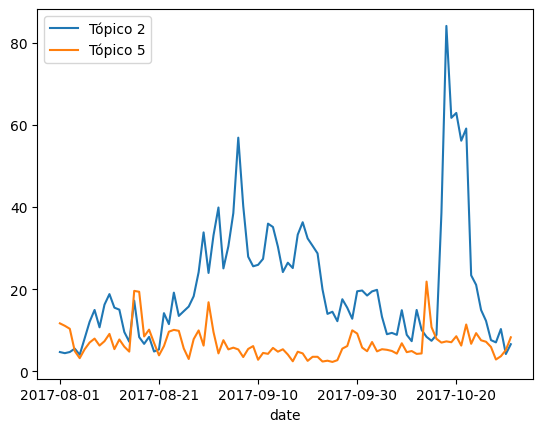

In [ ]:
fig, ax = plt.subplots()

data_agrupada_y_sumada['nmf_comp2'].plot(ax = ax, label = 'Tópico 2')
data_agrupada_y_sumada['nmf_comp5'].plot(ax = ax, label = 'Tópico 5')

plt.legend(loc = 'best')
plt.show()

Con esto último podemos comparar cómo evolucionaron dos tópicos, cuál tuvo mayor peso e identificar eventos importantes y relacionados.

### Cosas para llevarse, cosas para hacer

NMF es uno de los tantos algoritmos de detección de tópicos.
La salida son vectores que podemos interpretar como distribuciones en el espacio de tópicos y en el espacio de términos.

Más allá de lo bueno o malo de distintos algoritmos, la definición de los tópicos va a depender gran parte del corpus con el que trabajemos.
Muchas veces para forzar la emergencia de estas estructuras (más allá de forzarlas, quizás encontrarlas debajo del ruido) podemos jugar con:
- stopwords: las que usamos son suficientes? hay términos que aparecen en la definición de los tópicos que tal vez no son informativos y nos meten ruido? Podemos iterativamente actualizar la lista de stopwords para eliminar el clustering de documentos debido a palabras poco informativas.
- además de jugar con las stopwords podemos aprovechar los parámetros *min_df* y *max_df*, que nos van marcando un nivel de resolución de los tópicos que encontremos (por ejemplo, si ponemos max_df = 200, eliminando términos que aparezcan en más de 200 documentos, podríamos estar forzando a la emergencia de tópicos de menos de 200 documentos).

Pueden jugar con los distintos parámetros vistos a fin de encontrar tópicos más definidos.